<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/ANC_Phase_Inverted_Sample_Matching_(test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Active Noise Cancellation Using Phase-Inverted Sample Matching for Repetitive Noise Patterns

---

### Explanation of the Colab File:

This Colab file demonstrates a novel approach to Active Noise Cancellation (ANC) by leveraging a phase-inverted sample of a repetitive noise pattern. It targets scenarios where noise sources like engine hums, electric buzzes, or any other rhythmic disturbances are present. Here’s a breakdown of the steps involved:

1. **Audio File Loading**:
   - The user loads an audio file that simulates the continuous noise input (e.g., a recording of a noisy engine).
   - The waveform is resampled to a standard sampling rate for better processing.

2. **Sample Selection & Phase Inversion**:
   - A short sample (1-second) of the noise is randomly selected from the input waveform.
   - The phase of this sample is inverted to prepare for destructive interference.

3. **Matching for Destructive Interference**:
   - The script calculates how well the inverted sample aligns with each segment of the original noise, using a metric that seeks the opposite of correlation (MSE in this case).
   - The best matching point is identified, where applying the inverted sample would yield the most effective noise cancellation.

4. **Apply Inverted Sample with Repetition**:
   - To cover the continuous nature of the input noise, the inverted sample is repeated after the best match index.
   - Before this point, zero padding is used to avoid any premature interference.
   - The repeated inverted sample is combined with the original noise to create a waveform that minimizes the perceived noise.

5. **Visualization & Playback**:
   - Plots show the original waveform, the inverted 1-second sample, and the combined waveform to help visualize the impact of the cancellation process.
   - Audio playback is included to compare the original noise with the post-cancellation result.

### How to Implement in Real-Time:

To adapt this approach for real-time noise cancellation rather than using a static file, consider the following modifications:

1. **Live Audio Input**:
   - Replace the file-loading step with a real-time audio stream from a microphone or other input device.
   - Python libraries like `sounddevice` or `pyaudio` can be used to capture audio streams continuously.
   
2. **Sliding Window for Sample Selection**:
   - Instead of selecting a random sample from a preloaded file, continuously analyze the incoming stream using a sliding window approach to identify sections of the noise with stable characteristics.
   - Select and invert the phase of a segment (e.g., 1-second window) that represents the repetitive noise pattern well.

3. **Real-Time Matching**:
   - Continuously analyze the incoming stream for sections that match the phase-inverted sample.
   - Use a buffer to store recent audio data and calculate the match dynamically as new audio comes in.

4. **Streamed Application of Inverted Signal**:
   - Once a match is found, inject the inverted phase sample back into the output in real-time.
   - Repeat the sample as necessary to maintain cancellation over the noisy stream.
   - This can be done by modifying the output signal before it is played back through speakers or transmitted to another device.

5. **Latency Management**:
   - To reduce latency, optimize the matching calculation and use smaller windows.
   - Consider using parallel processing or GPU acceleration for faster computations.

6. **Testing in Different Environments**:
   - Implement a mechanism to adjust the sample duration or inverted phase intensity based on the real-time environment, especially if the noise characteristics change over time.
   - This can involve feedback loops that assess the cancellation effectiveness and adjust the approach dynamically.

### Summary:
This approach is ideal for scenarios where repetitive noise is prevalent, allowing a phase-inverted sample to destructively interfere with the incoming noise. By adapting it for real-time use, it can serve as a robust solution for creating quieter environments, whether in vehicles, industrial settings, or home applications with constant noise sources.

In [3]:
# Install necessary libraries
#!pip install torchaudio
#!pip install librosa

# Import required libraries
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
from google.colab import files

# Upload the audio file using the Colab file upload interface
uploaded = files.upload()


Saving 10000_Frequency_from_356_to_437_Hz_A.wav to 10000_Frequency_from_356_to_437_Hz_A.wav


Original Audio:


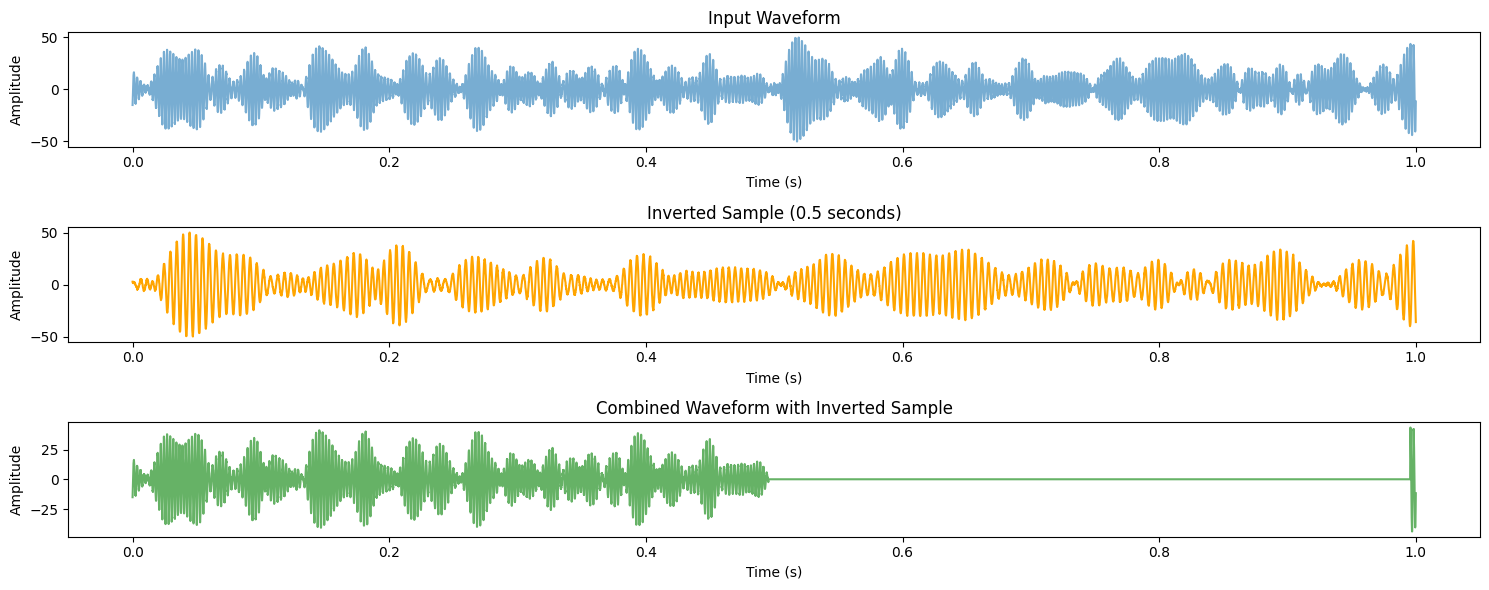

Inverted Sample Audio:


Combined Audio:


In [4]:
# Load the input waveform (noisy audio)
# Replace 'input_audio_path' with the path to your local audio file
input_audio_path = list(uploaded.keys())[0]
input_waveform, sr = torchaudio.load(input_audio_path)

# Display the original audio
print("Original Audio:")
ipd.display(ipd.Audio(input_waveform.numpy(), rate=sr))

# Define the sample duration and adjust if necessary
sample_duration = 0.5  # 0.5 seconds
sample_length = int(sr * sample_duration)
if sample_length > input_waveform.shape[1]:
    sample_length = int(input_waveform.shape[1] * 0.1)  # Adjust to 10% of input length

# Ensure the input waveform is long enough for selection
if input_waveform.shape[1] > sample_length:
    start_idx = np.random.randint(0, input_waveform.shape[1] - sample_length)
else:
    raise ValueError("Input waveform is too short to extract a suitable sample")

# Extract the sample and invert its phase
sample = input_waveform[:, start_idx:start_idx + sample_length]
inverted_sample = -sample  # Inverted phase for destructive interference

# Define function to find the best match for cancellation
def find_best_cancellation_index(continuous_input, inverted_sample):
    min_correlation = float('inf')
    best_index = 0

    # Iterate through possible positions for the inverted sample
    for i in range(continuous_input.shape[1] - inverted_sample.shape[1]):
        # Extract segment of continuous input matching the sample length
        segment = continuous_input[:, i:i + inverted_sample.shape[1]]

        # Compute "anti-correlation" score (the lower, the better for destructive interference)
        score = torch.sum((segment + inverted_sample) ** 2)

        # Track the best position for cancellation
        if score < min_correlation:
            min_correlation = score
            best_index = i

    return best_index

# Find the best index for applying the inverted sample
best_cancellation_index = find_best_cancellation_index(input_waveform, inverted_sample)

# Define function to apply the inverted sample at the best match index
def apply_cancellation(continuous_input, inverted_sample, best_match_idx):
    # Create a zero-padded output waveform of the same length as the input
    output_waveform = torch.zeros_like(continuous_input)

    # Add the inverted sample at the best match index for cancellation
    output_waveform[:, best_match_idx:best_match_idx + inverted_sample.shape[1]] = inverted_sample

    # Combine the input waveform and the output waveform (inverted phase sample)
    combined_waveform = continuous_input + output_waveform

    return combined_waveform

# Apply the cancellation at the identified location
combined_waveform = apply_cancellation(input_waveform, inverted_sample, best_cancellation_index)

# Plot the original, inverted sample, and combined waveforms
def plot_waveforms(input_waveform, inverted_sample, combined_waveform, sr):
    plt.figure(figsize=(15, 6))

    # Full duration for input and combined waveforms
    plt.subplot(3, 1, 1)
    plt.plot(np.linspace(0, input_waveform.shape[1] / sr, input_waveform.shape[1]), input_waveform.squeeze().numpy(), label='Input Waveform', alpha=0.6)
    plt.title('Input Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(np.linspace(0, 1, inverted_sample.shape[1]), inverted_sample.squeeze().numpy(), label='Inverted Sample', color='orange')
    plt.title('Inverted Sample (0.5 seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Full duration for combined waveform
    plt.subplot(3, 1, 3)
    plt.plot(np.linspace(0, combined_waveform.shape[1] / sr, combined_waveform.shape[1]), combined_waveform.squeeze().numpy(), label='Combined Waveform', alpha=0.6, color='green')
    plt.title('Combined Waveform with Inverted Sample')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Display the waveforms
plot_waveforms(input_waveform, inverted_sample, combined_waveform, sr)

# Display the audio for comparison
print("Inverted Sample Audio:")
ipd.display(ipd.Audio(inverted_sample.numpy(), rate=sr))

print("Combined Audio:")
ipd.display(ipd.Audio(combined_waveform.numpy(), rate=sr))
